# Imports
Import libraries and write settings here

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 50


# Matplotlib and seaborn for visualizations
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Resampling
from imblearn.over_sampling import SMOTENC, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler


# Scikit-learn utilities
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split,  GridSearchCV, RepeatedStratifiedKFold, cross_val_score


# Standard machine learning models
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import VotingClassifier #for Voting Classifier


/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
def movecol(df, cols_to_move=[], ref_col='', place='After'):
    
    cols = df.columns.tolist()
    if place == 'After':
        seg1 = cols[:list(cols).index(ref_col) + 1]
        seg2 = cols_to_move
    if place == 'Before':
        seg1 = cols[:list(cols).index(ref_col)]
        seg2 = cols_to_move + [ref_col]
    
    seg1 = [i for i in seg1 if i not in seg2]
    seg3 = [i for i in cols if i not in seg1 + seg2]
    
    return(df[seg1 + seg2 + seg3])

In [3]:
def classification(model, X_train, X_test, y_train, y_test, threshold):
    
    
    # Record score from cross cross-validation run
    cv_results = cross_val_score(model, X_train, y_train, cv=15, scoring='roc_auc')
   
    print("Cross validation results: %s" % ["{0:.3}".format(i) for i in cv_results])
    
    print("Mean of Cross validation results: %s" % "{0:.3f}".format(cv_results.mean()))
    
    
    # Fit the model:
    model.fit(X_train, y_train)
    
    
    # Print fraction of correct predictions on test data set:
    print("ROC-AUC on test data set: %s\n" % "{0:.3f}".format(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])))
                                                                                     
    
    # Make predictions on testing set:
    predicted_proba_test = model.predict_proba(X_test)
    y_test_pred = (predicted_proba_test[:,1] >= threshold).astype('int')
    
    
    # Print Classification report and Confusion_matrix
    cm = confusion_matrix(y_test, y_test_pred)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=model.classes_)
    
    disp.plot()
    plt.show()
    
    
    print('\n')
    print('Classification Report')
    print(classification_report(y_test, y_test_pred))
    
    #print(f1_score(y_test, y_test_pred))

# Dataset

## Load data 

In [4]:
# Load data and print the first 5 lines
df_raw = pd.read_csv('KidWai_cleaned_data_022022.csv')

In [5]:
df_raw.shape

(2471, 14)

In [6]:
df_raw.head()

,uid,treatment,daysTotal,GeneAllele,Nbr_FU_Visits,gender,race,hiv,diabetes,cvd,anyca,Nbr_of_TotalMeds,Nbr_of_Conditions,pae
0,1,EFAVIRENZ,30,1,7,Male,2.0,1,0,0,0,11,1,1
1,2,TRAMADOL,60,1,25,Male,3.0,1,0,0,0,23,1,1
2,3,OMEPRAZOLE,30,1,7,Male,1.0,1,0,0,0,4,1,1
3,4,IBUPROFEN,30,1,14,Male,4.0,1,0,0,0,1,1,1
4,5,IBUPROFEN,60,1,14,Male,2.0,1,1,0,0,2,2,1


## Extract VOIs for RQ1

In [7]:
voi_list = ["pae"
            , "GeneAllele"
            , "Nbr_of_TotalMeds"
            , "hiv"
            , "diabetes"
            , "cvd"
            , "anyca"
            , "Nbr_of_Conditions"]

In [8]:
df1 = df_raw.loc[:, voi_list]

In [9]:
df1.pae.value_counts()

1    2233
0     238
Name: pae, dtype: int64

In [10]:
df1.head()

,pae,GeneAllele,Nbr_of_TotalMeds,hiv,diabetes,cvd,anyca,Nbr_of_Conditions
0,1,1,11,1,0,0,0,1
1,1,1,23,1,0,0,0,1
2,1,1,4,1,0,0,0,1
3,1,1,1,1,0,0,0,1
4,1,1,2,1,1,0,0,2


In [11]:
df1.describe()

,pae,GeneAllele,Nbr_of_TotalMeds,hiv,diabetes,cvd,anyca,Nbr_of_Conditions
count,2471.000000,2471.000000,2471.000000,2471.000000,2471.000000,2471.000000,2471.000000,2471.000000
mean,0.903683,0.789154,9.180898,0.655200,0.242007,0.257386,0.261433,1.416026
std,0.295086,0.407992,6.736454,0.475399,0.428385,0.437282,0.439504,1.086600
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,1.000000,1.000000,8.000000,1.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,1.000000,13.000000,1.000000,0.000000,1.000000,1.000000,2.000000
max,1.000000,1.000000,47.000000,1.000000,1.000000,1.000000,1.000000,4.000000


In [12]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2471 entries, 0 to 2470
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   pae                2471 non-null   int64
 1   GeneAllele         2471 non-null   int64
 2   Nbr_of_TotalMeds   2471 non-null   int64
 3   hiv                2471 non-null   int64
 4   diabetes           2471 non-null   int64
 5   cvd                2471 non-null   int64
 6   anyca              2471 non-null   int64
 7   Nbr_of_Conditions  2471 non-null   int64
dtypes: int64(8)
memory usage: 154.6 KB


<font color='#7dff1d'> **There are no missing values in this data set.**</font>
    


## Feature scaling

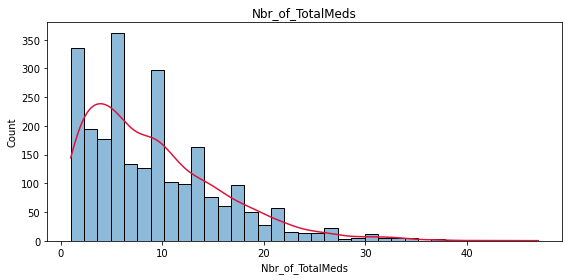

In [13]:
fig1, ax = plt.subplots(1, 1, figsize=(8,4))
sns.histplot(x='Nbr_of_TotalMeds'
             , data = df1
             , ax=ax
             , kde = True)
ax.lines[0].set_color('crimson')
ax.set_title('Nbr_of_TotalMeds')
plt.tight_layout()

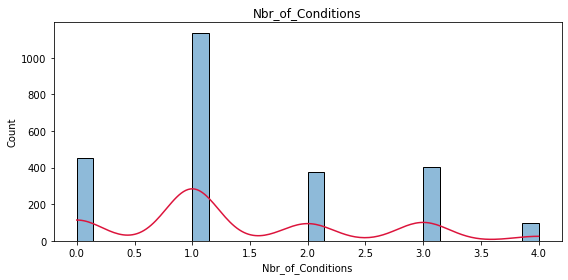

In [14]:
fig2, ax = plt.subplots(1, 1, figsize=(8,4))
sns.histplot(x='Nbr_of_Conditions'
             , data = df1
             , ax=ax
             , kde = True)
ax.lines[0].set_color('crimson')
ax.set_title('Nbr_of_Conditions')
plt.tight_layout()

<font color='#7dff1d'> **Variable `Nbr_of_TotalMeds` and `Nbr_of_Conditions` are not normally distributed, so `Min-Max Scaler` will be utilized to scale these two variables.**</font>
    


In [15]:
df2 = df1.copy()

In [16]:
scaler = MinMaxScaler()
df2['Nbr_of_TotalMeds_scaled'] = scaler.fit_transform(df2[['Nbr_of_TotalMeds']])
df2['Nbr_of_Conditions_scaled'] = scaler.fit_transform(df2[['Nbr_of_Conditions']])

In [17]:
df2.Nbr_of_TotalMeds.describe()

count    2471.000000
mean        9.180898
std         6.736454
min         1.000000
25%         4.000000
50%         8.000000
75%        13.000000
max        47.000000
Name: Nbr_of_TotalMeds, dtype: float64

In [18]:
df2.Nbr_of_TotalMeds_scaled.describe()

count    2471.000000
mean        0.177846
std         0.146445
min         0.000000
25%         0.065217
50%         0.152174
75%         0.260870
max         1.000000
Name: Nbr_of_TotalMeds_scaled, dtype: float64

In [19]:
df2.Nbr_of_Conditions.describe()

count    2471.000000
mean        1.416026
std         1.086600
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         4.000000
Name: Nbr_of_Conditions, dtype: float64

In [20]:
df2.Nbr_of_Conditions_scaled.describe()

count    2471.000000
mean        0.354006
std         0.271650
min         0.000000
25%         0.250000
50%         0.250000
75%         0.500000
max         1.000000
Name: Nbr_of_Conditions_scaled, dtype: float64

In [21]:
df2.drop(columns=['Nbr_of_TotalMeds', 'Nbr_of_Conditions'], axis=1, inplace=True)

In [22]:
df2.describe()

,pae,GeneAllele,hiv,diabetes,cvd,anyca,Nbr_of_TotalMeds_scaled,Nbr_of_Conditions_scaled
count,2471.000000,2471.000000,2471.000000,2471.000000,2471.000000,2471.000000,2471.000000,2471.000000
mean,0.903683,0.789154,0.655200,0.242007,0.257386,0.261433,0.177846,0.354006
std,0.295086,0.407992,0.475399,0.428385,0.437282,0.439504,0.146445,0.271650
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.065217,0.250000
50%,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.152174,0.250000
75%,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.260870,0.500000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Split training and Testing sets

- Training set: 70%
- Testing set: 30%

In [23]:
X = df2.drop(columns = ['pae'])
y = df2['pae']

In [24]:
X.shape

(2471, 7)

In [25]:
X.head()

,GeneAllele,hiv,diabetes,cvd,anyca,Nbr_of_TotalMeds_scaled,Nbr_of_Conditions_scaled
0,1,1,0,0,0,0.217391,0.25
1,1,1,0,0,0,0.478261,0.25
2,1,1,0,0,0,0.065217,0.25
3,1,1,0,0,0,0.000000,0.25
4,1,1,1,0,0,0.021739,0.50


In [26]:
y.shape

(2471,)

In [27]:
y.head()

0    1
1    1
2    1
3    1
4    1
Name: pae, dtype: int64

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2022)

In [29]:
X_train.shape, X_test.shape

((1729, 7), (742, 7))

In [30]:
y_train.shape, y_test.shape

((1729,), (742,))

In [31]:
df_train = X_train.copy()
df_test = X_test.copy()

In [32]:
df_train['pae'] = y_train.values
df_test['pae'] = y_test.values

In [33]:
df_train.shape

(1729, 8)

In [34]:
df_test.shape

(742, 8)

In [35]:
df_train.to_csv('data_train.csv', index=False)

In [36]:
df_test.to_csv('data_test.csv', index=False)

# Exploratory Data Analysis (EDA)

## Descriptive Analysis

### Continuous variables

In [37]:
v_cont = ["Nbr_of_TotalMeds_scaled", "Nbr_of_Conditions_scaled"]

In [38]:
df2.loc[:, v_cont].describe()

,Nbr_of_TotalMeds_scaled,Nbr_of_Conditions_scaled
count,2471.000000,2471.000000
mean,0.177846,0.354006
std,0.146445,0.271650
min,0.000000,0.000000
25%,0.065217,0.250000
50%,0.152174,0.250000
75%,0.260870,0.500000
max,1.000000,1.000000


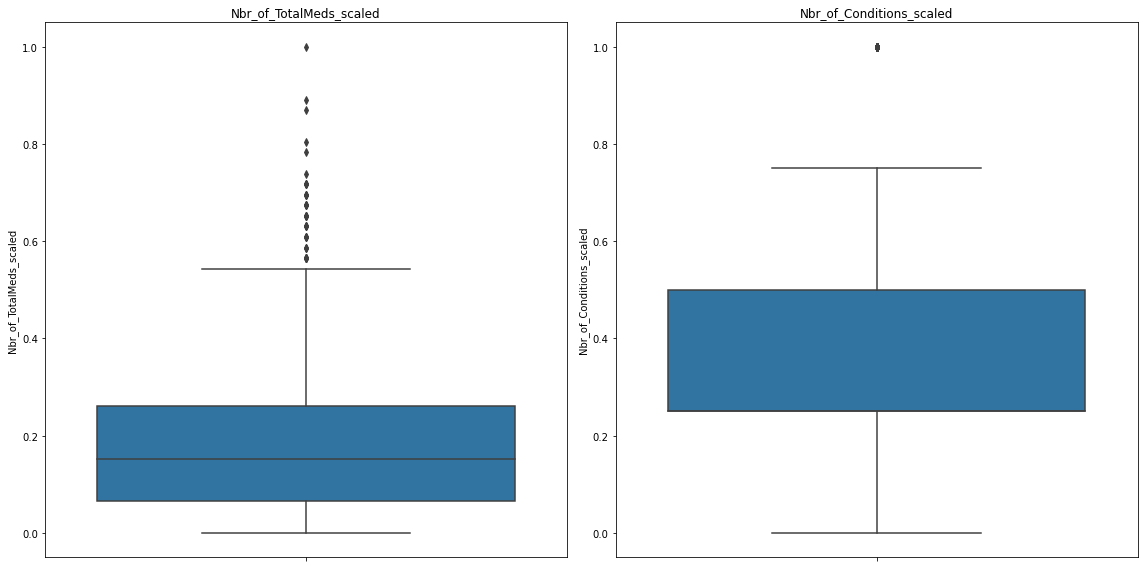

In [39]:
fig3, axes = plt.subplots(1, 2, figsize=(16,8))
for i in range(2):
    sns.boxplot(y=v_cont[i]
                , data = X_train, ax=axes[i])
    axes[i].set_title(v_cont[i])
plt.tight_layout()

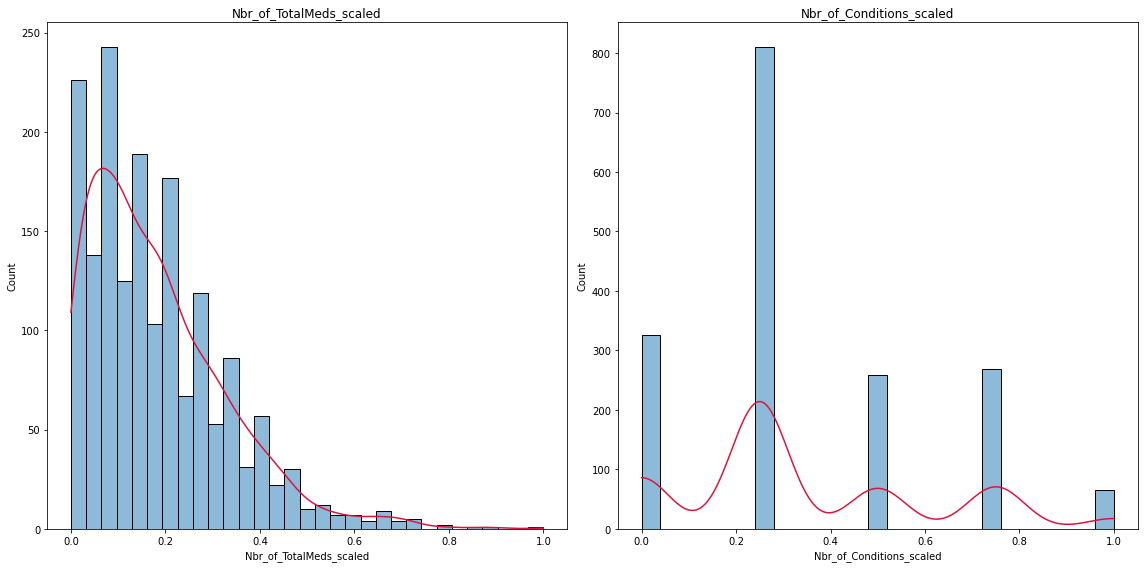

In [40]:
fig4, axes = plt.subplots(1, 2, figsize=(16,8))
for i in range(2):
    sns.histplot(x=v_cont[i]
                , data = X_train, ax=axes[i]
                , kde = True)
    axes[i].lines[0].set_color('crimson')
    axes[i].set_title(v_cont[i])
plt.tight_layout()

### Categorical variables

In [41]:
v_cat = ["GeneAllele"
         , "hiv"
         , "diabetes"
         , "cvd"
         , "anyca"]

In [42]:
for name_ in v_cat:
    s = X_train[[name_]]
    counts = s.value_counts()
    #percent = s.value_counts(normalize=True)
    percent100 = s.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
    #print(name_)
    display(pd.DataFrame({'Counts': counts, 'Percentage': percent100}))
    print('\n')

,Counts,Percentage
GeneAllele,,
1,1364,78.9%
0,365,21.1%


,Counts,Percentage
hiv,,
1,1120,64.8%
0,609,35.2%


,Counts,Percentage
diabetes,,
0,1320,76.3%
1,409,23.7%


,Counts,Percentage
cvd,,
0,1302,75.3%
1,427,24.7%


,Counts,Percentage
anyca,,
0,1290,74.6%
1,439,25.4%


## Explore the relationship between outcome variable and numerical variables

In [43]:
df_cont = X_train.loc[:, v_cont]

In [44]:
df_cont['pae'] = y_train.values

In [45]:
df_cont = movecol(df_cont
                 , cols_to_move=['pae']
                 , ref_col = 'Nbr_of_TotalMeds_scaled'
                 , place= "Before")

In [46]:
df_cont.head()

,pae,Nbr_of_TotalMeds_scaled,Nbr_of_Conditions_scaled
986,1,0.130435,0.00
468,1,0.152174,0.50
1904,1,0.673913,0.00
140,1,0.108696,0.25
42,1,0.021739,0.25


In [47]:
df_cont.shape

(1729, 3)

<Figure size 1152x1152 with 0 Axes>

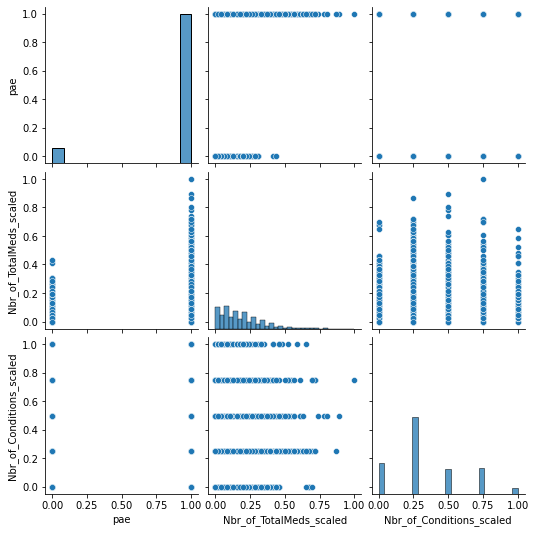

In [48]:
fig5 = plt.figure(figsize=(16, 16))
sns.pairplot(df_cont)
plt.show()

## Explore the relationship between outcome variable and categorical variables:


In [49]:
df_cat= X_train.loc[:, v_cat]

In [50]:
df_cat.shape

(1729, 5)

In [51]:
df_cat['pae'] = y_train.values

In [52]:
df_cat = movecol(df_cat
                , cols_to_move=['pae']
                , ref_col='GeneAllele'
                , place='Before')

In [53]:
df_cat.head()

,pae,GeneAllele,hiv,diabetes,cvd,anyca
986,1,1,0,0,0,0
468,1,1,1,0,1,0
1904,1,1,0,0,0,0
140,1,1,1,0,0,0
42,1,1,1,0,0,0


In [54]:
for name_ in v_cat:
    display(pd.crosstab(df_cat['pae'], df_cat[name_]))
    print('\n')

GeneAllele,0,1
pae,,
0,160,0
1,205,1364


hiv,0,1
pae,,
0,45,115
1,564,1005


diabetes,0,1
pae,,
0,138,22
1,1182,387


cvd,0,1
pae,,
0,120,40
1,1182,387


anyca,0,1
pae,,
0,119,41
1,1171,398


# Resampling

In [55]:
counts = y_train.value_counts()
percent100 = y_train.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
pd.DataFrame({'Counts': counts, 'Percentage': percent100})

,Counts,Percentage
1,1569,90.7%
0,160,9.3%


<font color='#7dff1d'>**This data set is significantly imbalanced, `Synthetic Minority Oversampling Technique `[(SMOTE)](https://imbalanced-learn.org/stable/over_sampling.html) will be utilized to resample the training data set.** </font>

In [56]:
X_train.describe()

,GeneAllele,hiv,diabetes,cvd,anyca,Nbr_of_TotalMeds_scaled,Nbr_of_Conditions_scaled
count,1729.000000,1729.000000,1729.000000,1729.000000,1729.000000,1729.000000,1729.000000
mean,0.788895,0.647773,0.236553,0.246964,0.253904,0.180263,0.346298
std,0.408211,0.477802,0.425088,0.431370,0.435369,0.146632,0.268517
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.065217,0.250000
50%,1.000000,1.000000,0.000000,0.000000,0.000000,0.152174,0.250000
75%,1.000000,1.000000,0.000000,0.000000,1.000000,0.260870,0.500000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [57]:
sampler = SMOTENC(categorical_features = [0, 1, 2, 3, 4]
                  , random_state=2022)

In [58]:
X_train_res, y_train_res = sampler.fit_resample(X_train, y_train)

In [59]:
X_train.shape

(1729, 7)

In [60]:
X_train_res.shape

(3138, 7)

In [61]:
X_train_res.head()

,GeneAllele,hiv,diabetes,cvd,anyca,Nbr_of_TotalMeds_scaled,Nbr_of_Conditions_scaled
0,1,0,0,0,0,0.130435,0.00
1,1,1,0,1,0,0.152174,0.50
2,1,0,0,0,0,0.673913,0.00
3,1,1,0,0,0,0.108696,0.25
4,1,1,0,0,0,0.021739,0.25


In [62]:
X_train_res.describe()

,GeneAllele,hiv,diabetes,cvd,anyca,Nbr_of_TotalMeds_scaled,Nbr_of_Conditions_scaled
count,3138.000000,3138.000000,3138.000000,3138.000000,3138.000000,3138.000000,3138.000000
mean,0.434672,0.691523,0.190886,0.238368,0.243467,0.135720,0.341831
std,0.495793,0.461938,0.393062,0.426153,0.429243,0.133698,0.267882
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.021739,0.250000
50%,0.000000,1.000000,0.000000,0.000000,0.000000,0.099174,0.250000
75%,1.000000,1.000000,0.000000,0.000000,0.000000,0.195652,0.500000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [63]:
counts = y_train_res.value_counts()
percent100 = y_train_res.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
pd.DataFrame({'Counts': counts, 'Percentage': percent100})

,Counts,Percentage
1,1569,50.0%
0,1569,50.0%


# Modeling

## RandomForestClassifier

### Hyperparameter tuning

In [64]:
rf = RandomForestClassifier(random_state=2022)

In [65]:
rf_parameters = {'n_estimators': [4, 6, 9, 10, 15], 
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1, 5, 8]
             }

In [66]:
rf_cv = GridSearchCV(rf
                 , scoring ='roc_auc'
                 , cv = 5
                 , param_grid = rf_parameters)

In [67]:
rf_cv.fit(X_train_res, y_train_res)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=2022),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [2, 3, 5, 10],
                         'max_features': ['log2', 'sqrt', 'auto'],
                         'min_samples_leaf': [1, 5, 8],
                         'min_samples_split': [2, 3, 5],
                         'n_estimators': [4, 6, 9, 10, 15]},
             scoring='roc_auc')

In [68]:
print(rf_cv.best_score_)

0.9792336480868714


In [69]:
print(rf_cv.best_params_)

{'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 10}


### Build RandomForest Model with best hyperparameters

In [70]:
rf = RandomForestClassifier(criterion = 'gini'
                            , max_depth = 10
                            , max_features = 'log2'
                            , min_samples_leaf = 1
                            , min_samples_split = 5
                            , n_estimators = 200
                            , random_state=2022)

Cross validation results: ['0.966', '0.944', '0.984', '0.994', '0.988', '0.977', '0.961', '0.986', '0.981', '0.985', '0.999', '0.99', '0.995', '0.974', '0.974']
Mean of Cross validation results: 0.980
ROC-AUC on test data set: 0.969



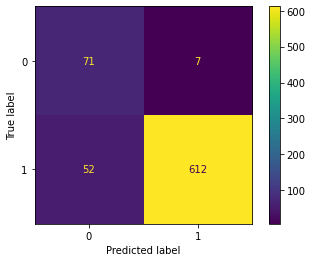



Classification Report
              precision    recall  f1-score   support

           0       0.58      0.91      0.71        78
           1       0.99      0.92      0.95       664

    accuracy                           0.92       742
   macro avg       0.78      0.92      0.83       742
weighted avg       0.95      0.92      0.93       742



In [71]:
classification(rf, X_train_res, X_test, y_train_res, y_test, threshold=0.5)

In [72]:
roc_auc = []

In [73]:
roc_auc.append([0.966, 0.944, 0.984, 0.994, 0.988, 0.977, 0.961
                , 0.986, 0.981, 0.985, 0.999, 0.990, 0.995, 0.974, 0.974])

In [74]:
roc_auc

[[0.966,
  0.944,
  0.984,
  0.994,
  0.988,
  0.977,
  0.961,
  0.986,
  0.981,
  0.985,
  0.999,
  0.99,
  0.995,
  0.974,
  0.974]]

## Xgboot

### Hyperparameter tuning
learning_rate, n_estimator, colsample_bytree, gamma

In [75]:
xgb = XGBClassifier(n_jobs=0
                   , use_label_encoder=False)

In [76]:
learning_rates = [0.01, 0.05, 0.1]
n_estimators = np.linspace(100, 200, 2, endpoint=True, dtype=int)
colsample_bytree = np.linspace(0.3, 0.8, 3, endpoint=True)

In [77]:
xgb_cv = GridSearchCV(xgb
                 , scoring = 'roc_auc'
                 , cv = 5
                 , param_grid = {'learning_rate': learning_rates
                                , 'n_estimators': n_estimators
                                , 'colsample_bytree': colsample_bytree})

In [78]:
xgb_cv.fit(X_train_res, y_train_res)

[10:56:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:56:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:56:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:56:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:56:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:56:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:56:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:56:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:56:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:56:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:56:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:56:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index i

[10:56:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:56:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:56:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:56:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:56:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:56:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:56:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:56:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:56:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:56:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index i

[10:56:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:56:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:56:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:56:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:56:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:56:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:56:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:56:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:56:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:56:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:56:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:56:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:56:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:56:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:56:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:56:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:56:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:56:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:56:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:56:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:56:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index i

[10:56:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:56:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:56:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:56:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:56:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:56:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:56:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index i

[10:56:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:56:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:56:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:56:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:56:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:56:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:56:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:56:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:56:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:56:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:56:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:56:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:56:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:56:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:56:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:56:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:56:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:56:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:56:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:56:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:56:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:56:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:56:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:56:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:56:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:56:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:56:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:56:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:56:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:56:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:56:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:56:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:56:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:56:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:56:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:56:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:56:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:56:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:56:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:56:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:56:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=0,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=No

In [79]:
print(xgb_cv.best_params_)

{'colsample_bytree': 0.55, 'learning_rate': 0.1, 'n_estimators': 200}


### Build Xgboots model

In [80]:
xgb = XGBClassifier(colsample_bytree=0.55
                   , learning_rate = 0.1
                   , n_estimators = 200
                   , reg_lambda = 100
                   , use_label_encoder = False)

/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:56:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:56:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:56:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:56:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:56:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:56:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:56:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:56:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:56:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:56:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:56:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:56:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:56:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:56:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:56:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Cross validation results: ['0.967', '0.944', '0.977', '0.987', '0.979', '0.968', '0.958', '0.982', '0.975', '0.986', '0.994', '0.984', '0.986', '0.979', '0.967']
Mean of Cross validation results: 0.975
[10:56:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
ROC-AUC on test data set: 0.972



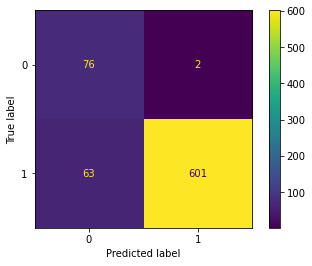



Classification Report
              precision    recall  f1-score   support

           0       0.55      0.97      0.70        78
           1       1.00      0.91      0.95       664

    accuracy                           0.91       742
   macro avg       0.77      0.94      0.82       742
weighted avg       0.95      0.91      0.92       742



In [81]:
classification(xgb, X_train_res, X_test, y_train_res, y_test, threshold=0.5)

In [82]:
roc_auc.append([0.967, 0.944, 0.977, 0.987, 0.979, 0.968
                , 0.958, 0.982, 0.975, 0.986, 0.994, 0.984
                , 0.986, 0.979, 0.967])

In [83]:
roc_auc

[[0.966,
  0.944,
  0.984,
  0.994,
  0.988,
  0.977,
  0.961,
  0.986,
  0.981,
  0.985,
  0.999,
  0.99,
  0.995,
  0.974,
  0.974],
 [0.967,
  0.944,
  0.977,
  0.987,
  0.979,
  0.968,
  0.958,
  0.982,
  0.975,
  0.986,
  0.994,
  0.984,
  0.986,
  0.979,
  0.967]]

## Support vector machine (SVM)

### Hyperparameter tuning

In [84]:
svc = SVC(probability = True)

In [85]:
svc_parameters = {'C': [1, 10, 100, 1000]
                  , 'gamma': [0.001, 0.0001]
                  , 'kernel': ['rbf']}

In [86]:
svc_cv = GridSearchCV(svc
                      , param_grid = svc_parameters
                      , scoring = 'roc_auc'
                      , cv = 5)

In [87]:
svc_cv.fit(X_train_res, y_train_res)

GridSearchCV(cv=5, estimator=SVC(probability=True),
             param_grid={'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                         'kernel': ['rbf']},
             scoring='roc_auc')

In [88]:
print(svc_cv.best_score_)

0.9669958647526284


In [89]:
print(svc_cv.best_params_)

{'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}


### Build SVM Model with best hyperparameters

In [90]:
X_train.columns

Index(['GeneAllele', 'hiv', 'diabetes', 'cvd', 'anyca',
       'Nbr_of_TotalMeds_scaled', 'Nbr_of_Conditions_scaled'],
      dtype='object')

In [91]:
svc = SVC(C = 1000
          , kernel = 'rbf'
          , gamma = 0.0001
          , probability = True)

Cross validation results: ['0.971', '0.928', '0.977', '0.978', '0.971', '0.961', '0.947', '0.965', '0.971', '0.981', '0.978', '0.976', '0.972', '0.974', '0.964']
Mean of Cross validation results: 0.968
ROC-AUC on test data set: 0.975



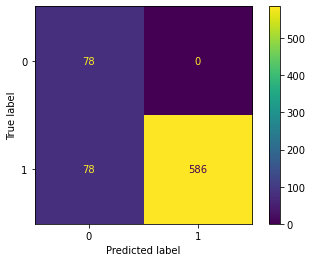



Classification Report
              precision    recall  f1-score   support

           0       0.50      1.00      0.67        78
           1       1.00      0.88      0.94       664

    accuracy                           0.89       742
   macro avg       0.75      0.94      0.80       742
weighted avg       0.95      0.89      0.91       742



In [92]:
classification(svc, X_train_res, X_test, y_train_res, y_test, threshold = 0.5)

In [93]:
roc_auc.append([0.971, 0.928, 0.977, 0.978
                , 0.971, 0.961, 0.947, 0.965
                , 0.971, 0.981, 0.978, 0.976
                , 0.972, 0.974, 0.964])

In [94]:
roc_auc

[[0.966,
  0.944,
  0.984,
  0.994,
  0.988,
  0.977,
  0.961,
  0.986,
  0.981,
  0.985,
  0.999,
  0.99,
  0.995,
  0.974,
  0.974],
 [0.967,
  0.944,
  0.977,
  0.987,
  0.979,
  0.968,
  0.958,
  0.982,
  0.975,
  0.986,
  0.994,
  0.984,
  0.986,
  0.979,
  0.967],
 [0.971,
  0.928,
  0.977,
  0.978,
  0.971,
  0.961,
  0.947,
  0.965,
  0.971,
  0.981,
  0.978,
  0.976,
  0.972,
  0.974,
  0.964]]

## Decision tree

### Hyperparameter tuning

In [95]:
dt = DecisionTreeClassifier(random_state=2022)

In [96]:
dt_parameters = {'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10, 50], 
              'min_samples_split': [2, 3, 50, 100],
              'min_samples_leaf': [1, 5, 8, 10]}

In [97]:
dt_cv = GridSearchCV(dt
                 , scoring ='roc_auc'
                 , cv = 5
                 , param_grid = dt_parameters)

In [98]:
dt_cv.fit(X_train_res, y_train_res)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=2022),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [2, 3, 5, 10, 50],
                         'max_features': ['log2', 'sqrt', 'auto'],
                         'min_samples_leaf': [1, 5, 8, 10],
                         'min_samples_split': [2, 3, 50, 100]},
             scoring='roc_auc')

In [99]:
print(dt_cv.best_score_)

0.9751246121747418


In [100]:
print(dt_cv.best_params_)

{'criterion': 'entropy', 'max_depth': 50, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 2}


### Build Decision Tree Model with best hyperparameters

In [101]:
dt = DecisionTreeClassifier(criterion = 'entropy'
                            , max_depth = 50
                            , max_features = 'log2'
                            , min_samples_leaf = 5
                            , min_samples_split = 2
                            , random_state=2022)

Cross validation results: ['0.97', '0.925', '0.967', '0.983', '0.977', '0.978', '0.958', '0.978', '0.966', '0.983', '0.994', '0.982', '0.992', '0.975', '0.975']
Mean of Cross validation results: 0.973
ROC-AUC on test data set: 0.960



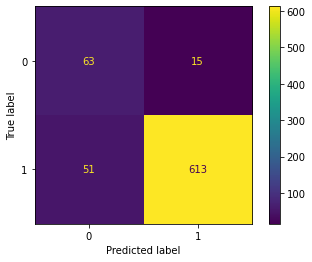



Classification Report
              precision    recall  f1-score   support

           0       0.55      0.81      0.66        78
           1       0.98      0.92      0.95       664

    accuracy                           0.91       742
   macro avg       0.76      0.87      0.80       742
weighted avg       0.93      0.91      0.92       742



In [102]:
classification(dt, X_train_res, X_test, y_train_res, y_test, threshold=0.5)

In [103]:
roc_auc.append([0.97, 0.925, 0.967, 0.983
                , 0.977, 0.978, 0.958, 0.978
                , 0.966, 0.983, 0.994, 0.982
                , 0.992, 0.975, 0.975])

In [104]:
roc_auc

[[0.966,
  0.944,
  0.984,
  0.994,
  0.988,
  0.977,
  0.961,
  0.986,
  0.981,
  0.985,
  0.999,
  0.99,
  0.995,
  0.974,
  0.974],
 [0.967,
  0.944,
  0.977,
  0.987,
  0.979,
  0.968,
  0.958,
  0.982,
  0.975,
  0.986,
  0.994,
  0.984,
  0.986,
  0.979,
  0.967],
 [0.971,
  0.928,
  0.977,
  0.978,
  0.971,
  0.961,
  0.947,
  0.965,
  0.971,
  0.981,
  0.978,
  0.976,
  0.972,
  0.974,
  0.964],
 [0.97,
  0.925,
  0.967,
  0.983,
  0.977,
  0.978,
  0.958,
  0.978,
  0.966,
  0.983,
  0.994,
  0.982,
  0.992,
  0.975,
  0.975]]

## KNN

### Hyperparameter tuning

In [105]:
knn = KNeighborsClassifier()

In [106]:
knn_parameters = {'n_neighbors': [3, 4, 5, 10]
                  , 'weights': ['uniform', 'distance']
                  , 'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute']
                  , 'leaf_size' : [10, 20, 30, 50]}

In [107]:
knn_cv = GridSearchCV(knn
                 , scoring ='roc_auc'
                 , cv = 5
                 , param_grid = knn_parameters)

In [108]:
knn_cv.fit(X_train_res, y_train_res)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'leaf_size': [10, 20, 30, 50],
                         'n_neighbors': [3, 4, 5, 10],
                         'weights': ['uniform', 'distance']},
             scoring='roc_auc')

In [109]:
print(knn_cv.best_score_)

0.97286377092202


In [110]:
print(knn_cv.best_params_)

{'algorithm': 'brute', 'leaf_size': 10, 'n_neighbors': 5, 'weights': 'uniform'}


### Build KNN model with best hyperparameters

In [111]:
knn = KNeighborsClassifier(algorithm = 'brute'
                          , leaf_size = 10
                          , n_neighbors = 5
                          , weights = 'uniform')

Cross validation results: ['0.969', '0.943', '0.977', '0.989', '0.977', '0.968', '0.969', '0.981', '0.971', '0.973', '0.982', '0.994', '0.991', '0.973', '0.96']
Mean of Cross validation results: 0.975
ROC-AUC on test data set: 0.957



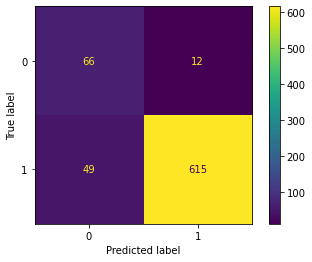



Classification Report
              precision    recall  f1-score   support

           0       0.57      0.85      0.68        78
           1       0.98      0.93      0.95       664

    accuracy                           0.92       742
   macro avg       0.78      0.89      0.82       742
weighted avg       0.94      0.92      0.92       742



In [112]:
classification(knn, X_train_res, X_test, y_train_res, y_test, threshold=0.5)

In [113]:
roc_auc.append([0.969, 0.943, 0.977, 0.989
                , 0.977, 0.968, 0.969, 0.981
                , 0.971, 0.973, 0.982, 0.994
                , 0.991, 0.973, 0.96])

In [114]:
roc_auc

[[0.966,
  0.944,
  0.984,
  0.994,
  0.988,
  0.977,
  0.961,
  0.986,
  0.981,
  0.985,
  0.999,
  0.99,
  0.995,
  0.974,
  0.974],
 [0.967,
  0.944,
  0.977,
  0.987,
  0.979,
  0.968,
  0.958,
  0.982,
  0.975,
  0.986,
  0.994,
  0.984,
  0.986,
  0.979,
  0.967],
 [0.971,
  0.928,
  0.977,
  0.978,
  0.971,
  0.961,
  0.947,
  0.965,
  0.971,
  0.981,
  0.978,
  0.976,
  0.972,
  0.974,
  0.964],
 [0.97,
  0.925,
  0.967,
  0.983,
  0.977,
  0.978,
  0.958,
  0.978,
  0.966,
  0.983,
  0.994,
  0.982,
  0.992,
  0.975,
  0.975],
 [0.969,
  0.943,
  0.977,
  0.989,
  0.977,
  0.968,
  0.969,
  0.981,
  0.971,
  0.973,
  0.982,
  0.994,
  0.991,
  0.973,
  0.96]]

## Ensembling

In [115]:
classifier_ = ['RF', 'XGB', 'SVM', 'DT', 'KNN']

In [116]:
df_roc_auc = pd.DataFrame(roc_auc, index=classifier_).T

In [117]:
df_roc_auc

,RF,XGB,SVM,DT,KNN
0,0.966,0.967,0.971,0.970,0.969
1,0.944,0.944,0.928,0.925,0.943
2,0.984,0.977,0.977,0.967,0.977
3,0.994,0.987,0.978,0.983,0.989
4,0.988,0.979,0.971,0.977,0.977
5,0.977,0.968,0.961,0.978,0.968
6,0.961,0.958,0.947,0.958,0.969
7,0.986,0.982,0.965,0.978,0.981
8,0.981,0.975,0.971,0.966,0.971
9,0.985,0.986,0.981,0.983,0.973


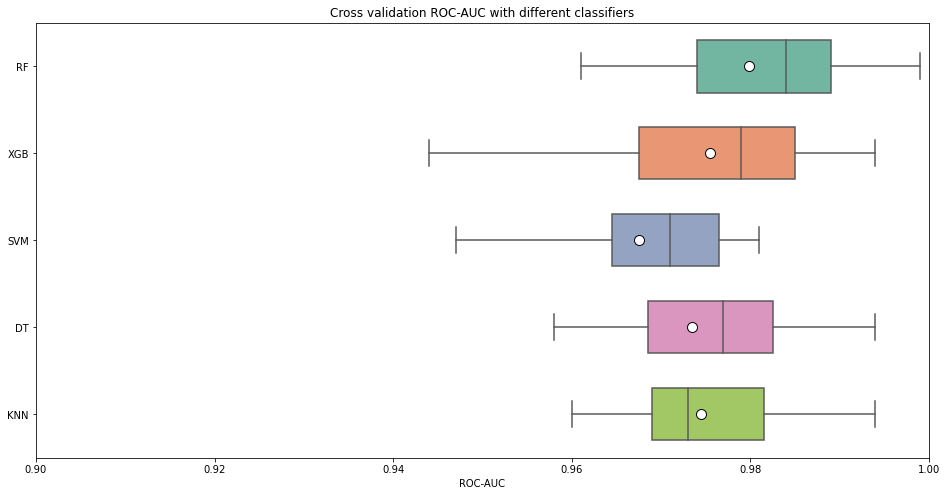

In [118]:
fig6, ax = plt.subplots(1, 1, figsize=(16,8))
ax = sns.boxplot(data=df_roc_auc, orient="h", palette="Set2", width=.6, showfliers=False
                , showmeans=True
                , meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"})
ax.set_yticklabels(classifier_)
ax.set_title('Cross validation ROC-AUC with different classifiers')
ax.set_xlabel('ROC-AUC')
ax.set_xlim(0.9, 1)
plt.show()

<font color='#7dff1d'>**Among these 5 models, the performance of SVM is relatively poor, the range of the results of cross validation are similar. All these 5 models will be used in the following ensembling model.** </font>

In [119]:
ensembleModel=VotingClassifier(estimators=[('RandomForest', rf), ('XGBoost', xgb), ('SVM', svc)
                                           , ('DecisionTree', dt), ('KNN', knn)], 
                                            voting='soft')

/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:57:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:57:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:57:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:57:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:57:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:57:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:57:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:57:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:57:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:57:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:57:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:57:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:57:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:57:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:57:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Cross validation results: ['0.969', '0.947', '0.984', '0.992', '0.985', '0.976', '0.964', '0.988', '0.976', '0.987', '0.998', '0.994', '0.994', '0.98', '0.974']
Mean of Cross validation results: 0.980


/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:57:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
ROC-AUC on test data set: 0.969



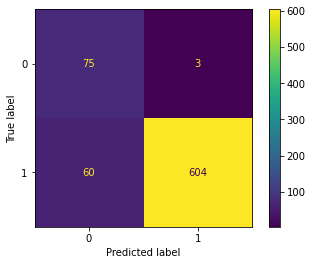



Classification Report
              precision    recall  f1-score   support

           0       0.56      0.96      0.70        78
           1       1.00      0.91      0.95       664

    accuracy                           0.92       742
   macro avg       0.78      0.94      0.83       742
weighted avg       0.95      0.92      0.92       742



In [120]:
classification(ensembleModel, X_train_res, X_test, y_train_res, y_test, threshold=0.5)

## Models performance comparison

In [121]:
predicted_proba_test_rf = rf.predict_proba(X_test)
predicted_proba_test_xgb = xgb.predict_proba(X_test)
predicted_proba_test_svc = svc.predict_proba(X_test)
predicted_proba_test_dt = dt.predict_proba(X_test)
predicted_proba_test_knn = knn.predict_proba(X_test)
predicted_proba_test_ensemble = ensembleModel.predict_proba(X_test)

In [122]:
false_pos_rate_rf, true_pos_rate_rf, proba_rf = roc_curve(y_test, predicted_proba_test_rf[:, -1])
false_pos_rate_xgb, true_pos_rate_xgb, proba_xgb = roc_curve(y_test, predicted_proba_test_xgb[:, -1])
false_pos_rate_svc, true_pos_rate_svc, proba_svc = roc_curve(y_test, predicted_proba_test_svc[:, -1])
false_pos_rate_dt, true_pos_rate_dt, proba_dt = roc_curve(y_test, predicted_proba_test_dt[:, -1])
false_pos_rate_knn, true_pos_rate_knn, proba_knn = roc_curve(y_test, predicted_proba_test_knn[:, -1])
false_pos_rate_ensemble, true_pos_rate_ensemble, proba_ensemble = roc_curve(y_test, predicted_proba_test_ensemble[:, -1])

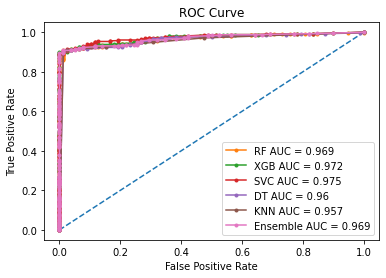

In [123]:
plt.figure()
plt.plot([0,1], [0,1], linestyle="--") # plot random curve
plt.plot(false_pos_rate_rf, true_pos_rate_rf, marker=".", label=f"RF AUC = {round(roc_auc_score(y_test, predicted_proba_test_rf[:, -1]), 3)}")
plt.plot(false_pos_rate_xgb, true_pos_rate_xgb, marker=".", label=f"XGB AUC = {round(roc_auc_score(y_test, predicted_proba_test_xgb[:, -1]), 3)}")
plt.plot(false_pos_rate_svc, true_pos_rate_svc, marker=".", label=f"SVC AUC = {round(roc_auc_score(y_test, predicted_proba_test_svc[:, -1]), 3)}")
plt.plot(false_pos_rate_dt, true_pos_rate_dt, marker=".", label=f"DT AUC = {round(roc_auc_score(y_test, predicted_proba_test_dt[:, -1]), 3)}")
plt.plot(false_pos_rate_knn, true_pos_rate_knn, marker=".", label=f"KNN AUC = {round(roc_auc_score(y_test, predicted_proba_test_knn[:, -1]), 3)}")
plt.plot(false_pos_rate_ensemble, true_pos_rate_ensemble, marker=".", label=f"Ensemble AUC = {round(roc_auc_score(y_test, predicted_proba_test_ensemble[:, -1]), 3)}")
plt.title("ROC Curve")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc="lower right")

# Final model

## Fit model

In [124]:
xgb = XGBClassifier(colsample_bytree=0.55
                   , learning_rate = 0.1
                   , n_estimators = 200
                   , reg_lambda = 100
                   , use_label_encoder = False)

/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:57:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:57:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:57:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:57:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:57:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:57:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:57:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:57:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:57:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:57:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:57:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:57:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:57:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:57:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:57:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Cross validation results: ['0.967', '0.944', '0.977', '0.987', '0.979', '0.968', '0.958', '0.982', '0.975', '0.986', '0.994', '0.984', '0.986', '0.979', '0.967']
Mean of Cross validation results: 0.975
[10:57:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
ROC-AUC on test data set: 0.972



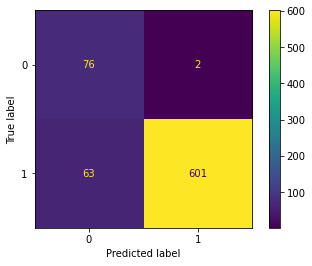



Classification Report
              precision    recall  f1-score   support

           0       0.55      0.97      0.70        78
           1       1.00      0.91      0.95       664

    accuracy                           0.91       742
   macro avg       0.77      0.94      0.82       742
weighted avg       0.95      0.91      0.92       742



In [125]:
classification(xgb, X_train_res, X_test, y_train_res, y_test, threshold=0.5)

## Optimal cutoff based on ROC curve

In [126]:
predicted_proba_test = xgb.predict_proba(X_test)

In [127]:
false_pos_rate, true_pos_rate, proba = roc_curve(y_test, predicted_proba_test[:, -1])

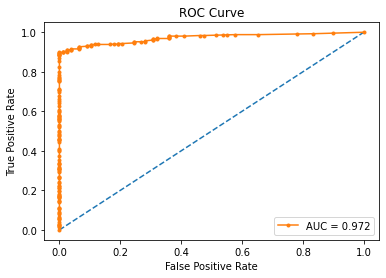

In [128]:
plt.figure()
plt.plot([0,1], [0,1], linestyle="--") # plot random curve
plt.plot(false_pos_rate, true_pos_rate, marker=".", label=f"AUC = {round(roc_auc_score(y_test, predicted_proba_test[:, -1]), 3)}")
plt.title("ROC Curve")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc="lower right")

In [129]:
i = np.arange(len(true_pos_rate)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(false_pos_rate, index=i)
                    ,'tpr' : pd.Series(true_pos_rate, index = i)
                    , '1-fpr' : pd.Series(1-false_pos_rate, index = i)
                    , 'tf' : pd.Series(true_pos_rate - (1-false_pos_rate), index = i)
                    , 'thresholds' : pd.Series(proba, index = i)})
roc.iloc[(roc.tf-0).abs().argsort()[:1]]

,fpr,tpr,1-fpr,tf,thresholds
119,0.064103,0.926205,0.935897,-0.009693,0.319418


## Re-fit the model using optimal threshold

[10:57:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:57:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:57:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:57:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:57:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:57:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:57:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:57:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:57:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:57:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:57:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:58:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:58:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:58:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:58:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/envs/ML_basic/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Cross validation results: ['0.967', '0.944', '0.977', '0.987', '0.979', '0.968', '0.958', '0.982', '0.975', '0.986', '0.994', '0.984', '0.986', '0.979', '0.967']
Mean of Cross validation results: 0.975
[10:58:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
ROC-AUC on test data set: 0.972



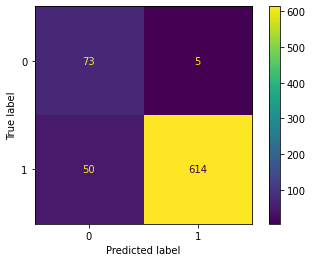



Classification Report
              precision    recall  f1-score   support

           0       0.59      0.94      0.73        78
           1       0.99      0.92      0.96       664

    accuracy                           0.93       742
   macro avg       0.79      0.93      0.84       742
weighted avg       0.95      0.93      0.93       742



In [130]:
classification(xgb, X_train_res, X_test, y_train_res, y_test, threshold=0.319418)

## Feature importance

In [131]:
feature_importance = pd.DataFrame(xgb.feature_importances_
                                  , columns=['Feature importance']
                                  , index = X_train.columns)

In [132]:
feature_importance.sort_values('Feature importance', inplace=True, ascending=False)

In [133]:
feature_importance

,Feature importance
GeneAllele,0.952166
Nbr_of_TotalMeds_scaled,0.026577
hiv,0.006404
diabetes,0.005714
cvd,0.003643
anyca,0.003419
Nbr_of_Conditions_scaled,0.002077


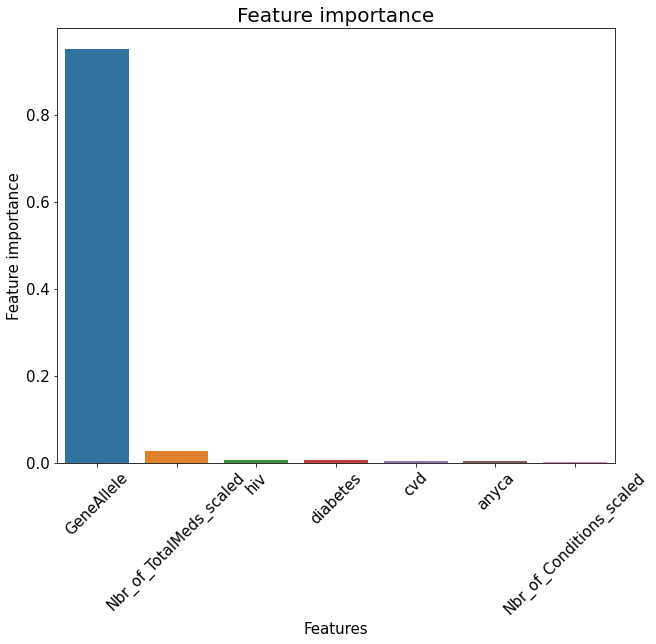

In [134]:
fig10, ax = plt.subplots(figsize=(10,8))
sns.barplot(x= feature_importance.index, y='Feature importance', data = feature_importance)
plt.xticks(rotation=45,fontsize=15)
plt.xlabel('Features', fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Feature importance', fontsize=15)
plt.title('Feature importance', fontsize=20)
plt.show()